# Predictor From Age and Gleason Score

The studies from which the datasets derive showed that the greatest predictor of treatment choice was doctor recommendation, which in turn was highly influenced by Gleason score and age. As a baseline for comparison with our future models, we will create a model solely based on Gleason score and age.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import DataCleaning as dc

In [3]:
dvd_original = pd.read_csv("data/DVD_Original.csv")
va_original = pd.read_csv("data/VA_Original.csv")

# retrieve the combined dataframe
merged_df = dc.merge(va_original, dvd_original)

In [4]:
merged_df.head(3)

,Anx11,Anx111,Anx112,Anx113,Anx12,Anx13,Anx51,Anx52,Anx53,Anx61,...,hispanic,irespmd,marry,mdrespme,native,pacific,pref_treatment,psa1,raceother,white
0,1.0,1.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,4.0,4.0,4.0,0.0,0.0,2.0,4.67,NaN,1.0
1,0.0,0.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,5.0,3.0,5.0,0.0,0.0,2.0,5.66,NaN,1.0
2,2.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,...,0.0,4.0,3.0,4.0,0.0,0.0,2.0,4.10,NaN,1.0


## Preparing and Exploring the Data

First, let's separate out the portion of the dataset we are going to use.

In [5]:
model_df = merged_df[['gleason', 'age', 'active_surv']].copy()

In [6]:
model_df.head(3)

,gleason,age,active_surv
0,7.0,45.0,0.0
1,7.0,56.0,0.0
2,6.0,53.0,0.0


We will clean this dataframe by removing patients who did not have a reported Gleason score or age and also those who didn't report a preferred treatment.

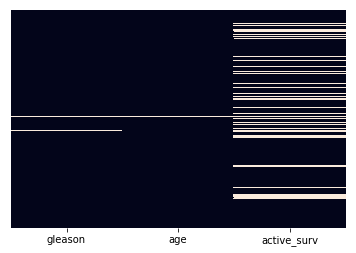

In [7]:
sns.heatmap(model_df.isnull(),yticklabels=False,cbar=False)

In [8]:
model_df.dropna(inplace=True)

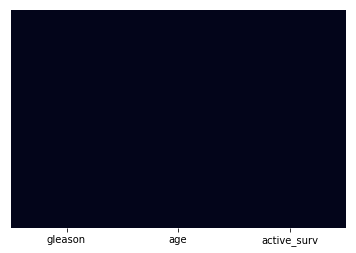

In [9]:
sns.heatmap(model_df.isnull(),yticklabels=False,cbar=False)

In [10]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 0 to 207
Data columns (total 3 columns):
gleason        380 non-null float64
age            380 non-null float64
active_surv    380 non-null float64
dtypes: float64(3)
memory usage: 11.9+ KB


So now we have a dataset of patients with complete data, and there's still a decent amount patients to train on. But we should investigate why there are so many patients that don't have a preferred treatment decision. The problem may be with the code that merges the datasets or the data itself.

### Visualizing the Data

Next, we're going to visualize the data to see if they show the trends that we are expecting.

In [11]:
# courtesy of Preethi
def plot_age(vis_df):
    df = vis_df.copy()
    bins = [40,50,60,70,80,90]
    df['categories'] = pd.cut(df['age'], bins)
    counts = df.groupby('categories', as_index=False)['active_surv'].mean() # get the mean value from each bin
    y_pos = np.arange(5)
    plt.bar(y_pos, counts['active_surv'], align='center', alpha=0.5)
    plt.xticks(y_pos, counts['categories'])
    plt.show()

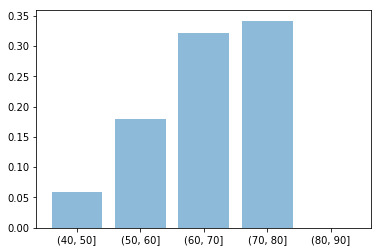

In [12]:
plot_age(model_df)

So the graph of age vs. proportion of active surveillance matches what we expect because we expect active surveillance to increase as remaining life expectancy decreases.

In [13]:
def plot_gleason(vis_df):
    df = vis_df.copy()
    gleason_split = df.groupby('gleason', as_index=False).mean()
    sns.barplot(x='gleason', y='active_surv', data=df)

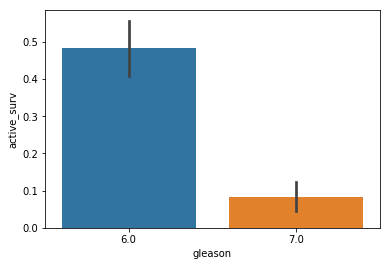

In [14]:
plot_gleason(model_df)

The plot for gleason value vs. proportion of active surveillance also matches what we'd expect because for less dangerous cancer, active surveillance is a more viable option. The Gleason score only has two distinct values, which we can split into separate columns.

### Gleason into Dummy Variable

To train on sklearn, we need to first convert our Gleason categorical variables into binary dummy variables.

In [15]:
gleason_dummy = pd.get_dummies(model_df['gleason'], drop_first=True)
model_df_sub = model_df.drop(['gleason'], axis=1)

In [16]:
train_df = pd.concat([gleason_dummy, model_df_sub], axis=1)

In [17]:
train_df.head()

,7.0,age,active_surv
0,1,45.0,0.0
1,1,56.0,0.0
2,0,53.0,0.0
3,1,65.0,0.0
4,0,52.0,1.0


So now that our training dataframe looks good, we can move onto training our model.

Note: only the column for a Gleason score of 7 is created because having both in the training data is problematic because there is a perfect relationship between either having Gleason score of 6 or 7.

## Training Models

### Logistic Regression

First, we have to split our model into test and training.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('active_surv',axis=1), 
                                                    train_df['active_surv'], test_size=0.30)

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
predictions_log = logmodel.predict(X_test)

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rfc = RandomForestClassifier(n_estimators=600)

In [25]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
predictions_rfc = rfc.predict(X_test)

### SVM

In [27]:
from sklearn.svm import SVC

In [28]:
svmmodel = SVC()

In [29]:
svmmodel.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
predictions_svm = svmmodel.predict(X_test)

Now let's find the best hyperparameters for this SVM.

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [33]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

In [34]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7078651685393258, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7078651685393258, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.7159090909090909, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7078651685393258, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7078651685393258, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7159090909090909, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ............................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=100, gamma=0.1, kernel=rbf, score=0.797752808988764, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.7840909090909091, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV]  C=100, gamma=0.01, kernel=rbf, score=0.7528089887640449, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV]  C=100, gamma=0.01, kernel=rbf, score=0.797752808988764, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV]  C=100, gamma=0.01, kernel=rbf, score=0.8181818181818182, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.7528089887640449, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.7415730337078652, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [35]:
predictions_svm_grid = grid.predict(X_test)

## Evaluating Models

### Logistic Regression

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(confusion_matrix(y_test, predictions_log))

[[80  9]
 [14 11]]


In [38]:
print(classification_report(y_test, predictions_log))

             precision    recall  f1-score   support

        0.0       0.85      0.90      0.87        89
        1.0       0.55      0.44      0.49        25

avg / total       0.79      0.80      0.79       114



It looks like logistic regression didn't do a great job of predicting patients who chose active surveillance.

### Random Forest

In [39]:
print(confusion_matrix(y_test,predictions_rfc))

[[79 10]
 [15 10]]


In [40]:
print(classification_report(y_test,predictions_rfc))

             precision    recall  f1-score   support

        0.0       0.84      0.89      0.86        89
        1.0       0.50      0.40      0.44        25

avg / total       0.77      0.78      0.77       114



### SVM

In [41]:
print(confusion_matrix(y_test, predictions_svm))

[[82  7]
 [16  9]]


In [42]:
print(classification_report(y_test, predictions_log))

             precision    recall  f1-score   support

        0.0       0.85      0.90      0.87        89
        1.0       0.55      0.44      0.49        25

avg / total       0.79      0.80      0.79       114



### SVM Tuned

In [43]:
print(confusion_matrix(y_test, predictions_svm_grid))

[[77 12]
 [11 14]]


In [44]:
print(classification_report(y_test, predictions_svm_grid))

             precision    recall  f1-score   support

        0.0       0.88      0.87      0.87        89
        1.0       0.54      0.56      0.55        25

avg / total       0.80      0.80      0.80       114



## Results

In [45]:
print(classification_report(y_test, predictions_svm_grid))

             precision    recall  f1-score   support

        0.0       0.88      0.87      0.87        89
        1.0       0.54      0.56      0.55        25

avg / total       0.80      0.80      0.80       114



So after this quick exploration throwing a dataset consisting of only two variables into various machine learning algorithms, we've got a decent baseline model with the tuned SVM. Although, we are missing a good amount of positive active surveillance patients. However, these models were hardly tuned, so performance could potententially be better even for the control.

Also, I can see how analysis of the patient conversations can fit in with the model because we may be missing some positive active surveillance patients because in some cases, patient preferences play a role, and the degree of this role may be elucidated by the texts.

In [46]:
model_df.groupby('active_surv').agg('count')

,gleason,age
active_surv,,
0.0,278,278
1.0,102,102


The percentage of patients who actually chose active surveillance is around 27%, so at least our results are better than if the prediction was assigned by chance. How much better? I don't know. I don't stats.